# Step 1 - Data Gathering

### Use Tweept to scrape from twitter's search api and save scraped tweets to a csv

In [11]:
#import dependencies
import requests
import json
from pprint import pprint
import re 
import tweepy 
from tweepy import OAuthHandler


In [ ]:
# Twitter credentials
consumer_key = "Q6DjcmJ4BqhblkTnEskefYHFa"
consumer_secret = "6mA3sRtm7nKjXQixwJxLh6TwP2oSKkztAe7KSPk835zi8USgvb"
access_token = "1152636165121429504-nfHnhZnmSKUCOsvHXvmrG1TLl8H7mf"
access_token_secret = "oEDWr43X5yBpYsX7h4ooLnKQklVbluMaG2YTclikki9g1"

#url = "https://api.twitter.com/1.1/search/tweets.json"
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

auth.set_access_token(access_token, access_token_secret)

In [ ]:
#api call
api = tweepy.API(auth, wait_on_rate_limit=True)
max_tweets=1000
query='#climatecrisis OR #climatechange OR #climategate OR #globalwarming OR #climatehoax OR #climateskeptic'
searched_tweets = [status._json for status in tweepy.Cursor(api.search,  q=query).items(max_tweets)]

In [ ]:
#print one tweet to examine data structure
pprint(searched_tweets[0])

In [ ]:
#print all tweets to verify json object
for tweet in searched_tweets:
    print(tweet)

In [ ]:
#Load json into a pandas dataframe
import pandas as pd
climate_data_df = pd.DataFrame(searched_tweets)
climate_data_df.head()

In [ ]:
#drop unwanted columns
reduced_df = climate_data_df[['id', 'created_at', 'retweet_count', 'favorite_count','text', 'user']]
reduced_df.head()

In [ ]:
#parse 'user' column (a json dict.) for screen name and user description. Create columns in dataframe
reduced_df['user_name'] = reduced_df.user.map(lambda x:x['screen_name'])
reduced_df['user_info'] = reduced_df.user.map(lambda x:x['description'])

In [ ]:
reduced_df.to_csv('tweet_data.csv')

# Step 2 - Data Preprocessing & Visualization

### Clean tweet text. Remove special characters and stop words

In [4]:
import numpy as np
import pandas as pd
import re
import warnings

#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
tweets = pd.read_csv('tweet_data.csv', encoding = "ISO-8859-1")
tweets.head()

,Unnamed: 0,id,created_at,retweet_count,favorite_count,text,user,user_name,user_info
0,0,1.156450e+18,Wed Jul 31 06:03:51 +0000 2019,0,0,#JÃ¤Ã¤kausi tulossa. #ClimateChange #ilmastonm...,"{'id': 867609472763662337, 'id_str': '86760947...",PyykonenPetteri,NaN
1,1,1.156450e+18,Wed Jul 31 06:03:50 +0000 2019,6,0,"RT @TheB1M: These buildings are ""eating"" smog ...","{'id': 1060824369537208320, 'id_str': '1060824...",TCJ_UK,Fastest growing UK Construction Blog & Quarter...
2,2,1.156450e+18,Wed Jul 31 06:03:44 +0000 2019,1,0,RT @SadrachNirere: @Chad_Stan33 @Nellaroma87 @...,"{'id': 2561925975, 'id_str': '2561925975', 'na...",amdfupdate,Africa Media Development Foundation is a media...
3,3,1.156450e+18,Wed Jul 31 06:03:43 +0000 2019,0,0,@CNN why was #ClimateChange not A way bigger...,"{'id': 1921555627, 'id_str': '1921555627', 'na...",Briellevue,"Startup Executive Consultant, VP of Sales. ð..."
4,4,1.156450e+18,Wed Jul 31 06:03:37 +0000 2019,166,0,RT @350: â ï¸ BREAKING: Pacific Island leade...,"{'id': 3301211182, 'id_str': '3301211182', 'na...",mattplourd,"NYU Tisch 23â | Student, theatre geek, domes..."


In [5]:
tweets['text'][1]

'RT @TheB1M: These buildings are "eating" smog - FULL VIDEO: https://t.co/lbzEJKiSFt #construction #pollution #climatechange https://t.co/67â\x80¦'

In [6]:
#Preprocessing 
tweets['tweetos'] = '' 

#add tweetos first part
for i in range(len(tweets['text'])):
    try:
        tweets['tweetos'][i] = tweets['text'].str.split(' ')[i][0]
    except AttributeError:    
        tweets['tweetos'][i] = 'other'

#Preprocessing tweetos. select tweetos contains 'RT @'
for i in range(len(tweets['text'])):
    if tweets['tweetos'].str.contains('@')[i]  == False:
        tweets['tweetos'][i] = 'other'
        
# remove URLs, RTs, and twitter handles
for i in range(len(tweets['text'])):
    tweets['text'][i] = " ".join([word for word in tweets['text'][i].split()
                                if 'http' not in word and '@' not in word and '<' not in word])


tweets['text'][1]

'RT These buildings are "eating" smog - FULL VIDEO: #construction #pollution #climatechange'

In [114]:
#delete certains punctuations, put the text in lower case and delete the double space with the function apply.
tweets['text'] = tweets['text'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
tweets['text'] = tweets['text'].apply(lambda x: re.sub('  ', ' ', x))
tweets['text'][1]

'rt these buildings are "eating" smog - full video construction pollution climatechange'

In [115]:
clean_tweets = tweets['text']
clean_tweets.to_csv('training_set.csv')


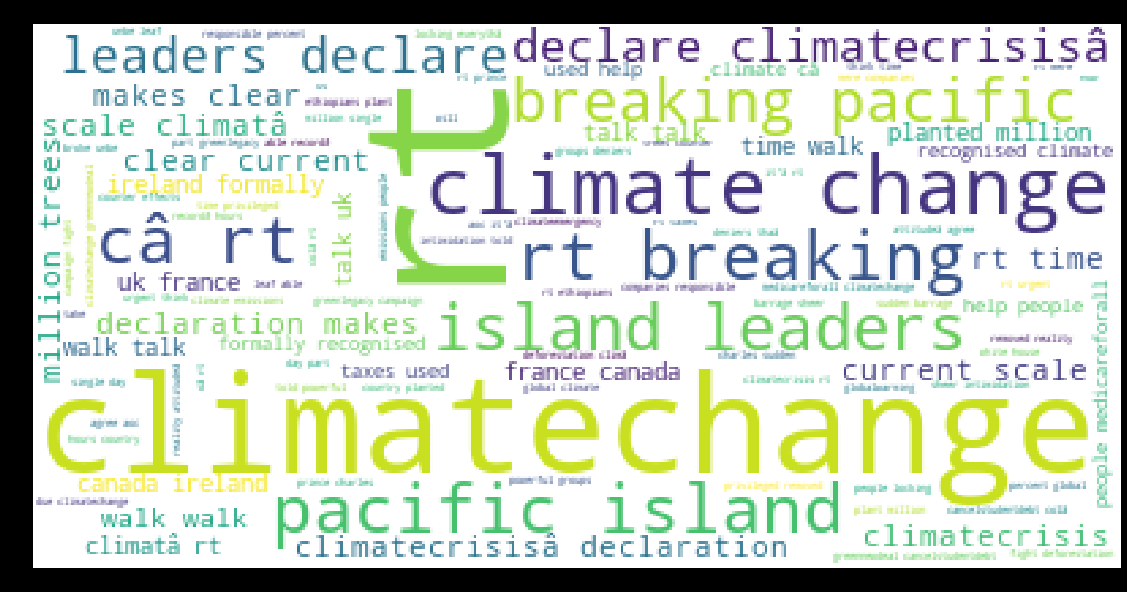

In [9]:
#wordcloud visualization of cleaned data
def wordcloud(tweets,col):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in tweets[col]]))
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Climate Change - Real or Hoax?")
wordcloud(tweets,'text')

# Step 3 - Sentiment Analysis using NTLK & VADER

In [14]:
#TF-IDF Features
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
tweets['text_lem'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in tweets['text']]       

vectorizer = TfidfVectorizer(max_df=0.5,max_features=10000,min_df=10,stop_words='english',use_idf=True)

X = vectorizer.fit_transform(tweets['text_lem'].str.upper())

sid = SentimentIntensityAnalyzer()

tweets['sentiment_compound_polarity']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['compound'])
tweets['sentiment_neutral']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['neu'])
tweets['sentiment_negative']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['neg'])
tweets['sentiment_pos']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['pos'])
tweets['sentiment_type']=''
tweets.loc[tweets.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
tweets.loc[tweets.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
tweets.loc[tweets.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'

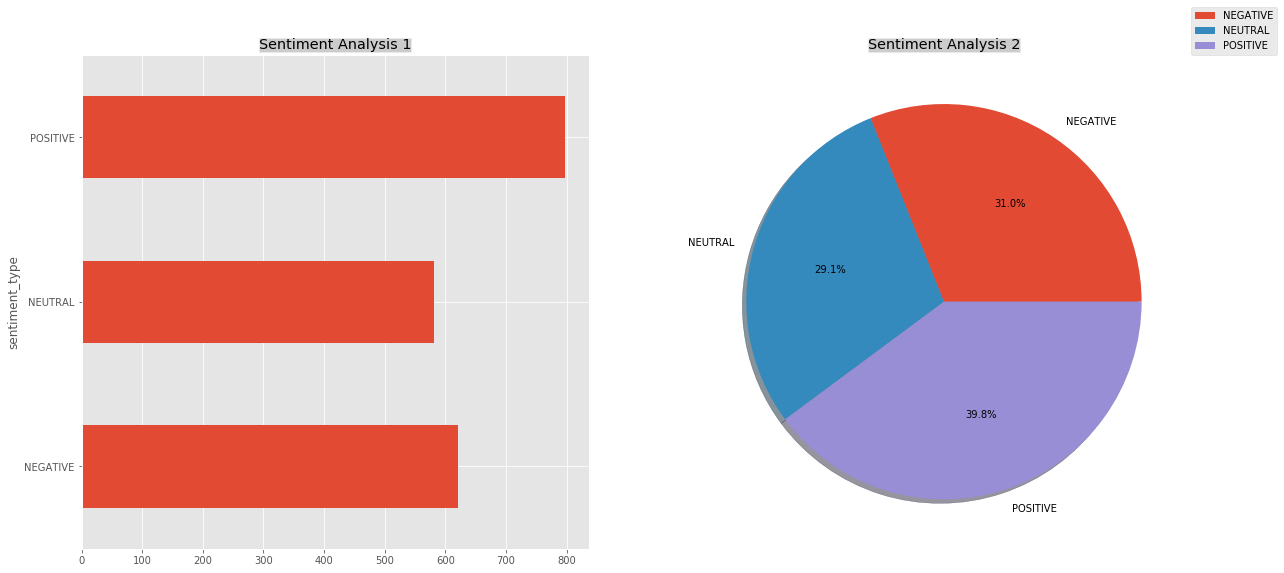

In [19]:
tweets_sentiment = tweets.groupby(['sentiment_type'])['sentiment_neutral'].count()
tweets_sentiment.rename("",inplace=True)
explode = (1, 0, 0)
plt.subplot(221)
tweets_sentiment.transpose().plot(kind='barh',figsize=(20, 20))
plt.title('Sentiment Analysis 1', bbox={'facecolor':'0.8', 'pad':0})
plt.subplot(222)
tweets_sentiment.plot(kind='pie',figsize=(20, 20),autopct='%1.1f%%',shadow=True)
plt.legend(bbox_to_anchor=(1, 1), loc=3, borderaxespad=0.)
plt.title('Sentiment Analysis 2', bbox={'facecolor':'0.8', 'pad':0})
plt.show()

In [32]:
neg_sample = tweets[tweets.sentiment_type == 'NEGATIVE'].text.reset_index(drop = True)[0:10]
print(neg_sample)

0    rt these buildings are "eating" smog - full vi...
1    rt over 4 billion people in the world use soci...
2    and some still dispute climate change globalwa...
3    rt "the science is crystal clear and leaves oi...
4    âhuman carbon emissions cannot cause any cli...
5    rt four terrifying climate change stories happ...
6    rt " in the case of particularly climate-damag...
7    rt extinctionrebellion protesters at bay amp k...
8    rt ethiopians plant more than 350 million ð³...
9    rt ethiopians plant more than 350 million ð³...
Name: text, dtype: object


In [33]:
neg_sample.to_csv('negative.csv')

In [29]:
pos_sample = tweets[tweets.sentiment_type == 'POSITIVE'].text.reset_index(drop = True)[0:10]
print(pos_sample)

0    why was climatechange not a way bigger priorit...
1    rt â ï¸ breaking pacific island leaders decl...
2    rt good to see this published in financial pos...
3    rt new published science challenges the curren...
4    rt â ï¸ breaking pacific island leaders decl...
5    rt welcome to the new normal canadians act now...
6    rt voting for a republican is like lightning a...
7    rt â ï¸ breaking pacific island leaders decl...
8    rt a mere 100 companies are responsible for 71...
9    rt "itâs crazy to think that we can have unl...
Name: text, dtype: object


In [30]:
pos_sample.to_csv('positive.csv')

In [27]:
neu_sample = tweets[tweets.sentiment_type == 'NEUTRAL'].text.reset_index(drop = True)[0:10]
print(neu_sample)

0    jã¤ã¤kausi tulossa climatechange ilmastonmuuto...
1    so this is my dads company 100% biodegradable ...
2    on bbcnews this morning hottest 10 years in hi...
3    rt science and statistics indeed say that ther...
4    rt we're one hour in the demdebate and climate...
5    rt that's really big does he know the 'univers...
6    rt time to walk the walk not just talk the tal...
7    rt i've been researching climate for years i k...
8    wildlife photographer amp filmmaker of the doc...
9    met office uk's 10 hottest years on record occ...
Name: text, dtype: object


In [28]:
neu_sample.to_csv('neutral.csv')

# Step 4 - Building an ML model for Classification 